In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import miceforest as mf

# Read data
cis2018 = pd.read_csv(f"/Volumes/K的1TB/ECO480/Term_Paper/Data/2018sub-data.txt")

# List of variables to keep
variables_to_keep = ["efmjie", "fschhldm", "efagofmp", "efagyfmp", "efalimo", "efalip", "efcapgn", "efccar", "efchtxb", 
"efcpqpp", "efearng", "efgi", "efgstxc", "efgtr", "efinva", "efmjsi", "efoasgi", "efogovtr", "efothinc", "efpen", "efpenrec", "efphpr", "efpvtxc", "efrppc", "efrspwi", "efsapis", "efsemp", 
"efsize", "efuiben", "efwkrcp", "prov", "dwltyp", "dwtenr", "marstp","eftyp","hlev2g","sex","immst","uszgap"]

Since we aim to build a predictive model for food insecurity in the unit of household, I used variables in economic families, i.e., those starting with "ef".

In [5]:
# Keep observations where efmjieh equals 1. efmjie is the indicator of major income earner in the economic family, so it is equivalent to focus just on those observations to consider the whole economic family.
new_dataset_efmjieh1 = cis2018[variables_to_keep]
new_dataset_efmjieh1 = new_dataset_efmjieh1[new_dataset_efmjieh1['efmjie'] == 1]

# Remove column 'efmjie'
new_dataset_efmjieh1 = new_dataset_efmjieh1.drop(columns=['efmjie'])

# Set certain values to NaN. I recoded some variables according to the codebook of CIS because they are not stated.
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['dwltyp'] >= 6, 'dwltyp'] = np.nan
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['marstp'] >= 6, 'marstp'] = np.nan
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['eftyp'] >= 96, 'eftyp'] = np.nan
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['hlev2g'] >= 6, 'hlev2g'] = np.nan


 Data Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 42437 entries, 0 to 94334
Data columns (total 39 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   efmjie    42437 non-null  int64
 1   fschhldm  42437 non-null  int64
 2   efagofmp  42437 non-null  int64
 3   efagyfmp  42437 non-null  int64
 4   efalimo   42437 non-null  int64
 5   efalip    42437 non-null  int64
 6   efcapgn   42437 non-null  int64
 7   efccar    42437 non-null  int64
 8   efchtxb   42437 non-null  int64
 9   efcpqpp   42437 non-null  int64
 10  efearng   42437 non-null  int64
 11  efgi      42437 non-null  int64
 12  efgstxc   42437 non-null  int64
 13  efgtr     42437 non-null  int64
 14  efinva    42437 non-null  int64
 15  efmjsi    42437 non-null  int64
 16  efoasgi   42437 non-null  int64
 17  efogovtr  42437 non-null  int64
 18  efothinc  42437 non-null  int64
 19  efpen     42437 non-null  int64
 20  efpenrec  42437 non-null  int64
 21  efphpr    42437 non-nul

## Data Preprocessing and Initial Analysis

### Missing Values

I checked the number of missing values for each variable to identify any variables that might need to be dropped due to excessive missing data. Notably, there are no missing values in our dependent variable, ensuring that we do not need to drop any observations. 

In [ ]:
missing_values_count = new_dataset_efmjieh1.isnull().sum()
print('\n Missing Value Count')
print(missing_values_count)
print('\n Missing Value Percentage')
new_dataset_efmjieh1.isnull().mean()


 Missing Value Count
fschhldm       0
efagofmp       0
efagyfmp       0
efalimo        0
efalip         0
efcapgn        0
efccar         0
efchtxb        0
efcpqpp        0
efearng        0
efgi           0
efgstxc        0
efgtr          0
efinva         0
efmjsi         0
efoasgi        0
efogovtr       0
efothinc       0
efpen          0
efpenrec       0
efphpr         0
efpvtxc        0
efrppc         0
efrspwi        0
efsapis        0
efsemp         0
efsize         0
efuiben        0
efwkrcp        0
prov           0
dwltyp      2277
dwtenr         0
marstp      1859
eftyp        859
hlev2g      1824
sex            0
immst          0
uszgap         0
dtype: int64

 Missing Value Percentage


fschhldm    0.000000
efagofmp    0.000000
efagyfmp    0.000000
efalimo     0.000000
efalip      0.000000
efcapgn     0.000000
efccar      0.000000
efchtxb     0.000000
efcpqpp     0.000000
efearng     0.000000
efgi        0.000000
efgstxc     0.000000
efgtr       0.000000
efinva      0.000000
efmjsi      0.000000
efoasgi     0.000000
efogovtr    0.000000
efothinc    0.000000
efpen       0.000000
efpenrec    0.000000
efphpr      0.000000
efpvtxc     0.000000
efrppc      0.000000
efrspwi     0.000000
efsapis     0.000000
efsemp      0.000000
efsize      0.000000
efuiben     0.000000
efwkrcp     0.000000
prov        0.000000
dwltyp      0.053656
dwtenr      0.000000
marstp      0.043806
eftyp       0.020242
hlev2g      0.042981
sex         0.000000
immst       0.000000
uszgap      0.000000
dtype: float64

### Variables with Missing Values

| Variable | Description | Variable Type | Count | Proportion |
| --- | --- | --- | --- | --- |
| dwltyp | Type of dwelling | Categorical | 2277 | 0.053656 |
| marstp | Marital status | Categorical | 1859 | 0.043806 |
| eftyp | Economic family type | Categorical | 859 | 0.020242 |
| hlev2g | Highest level of education of person | Ordinal | 1824 | 0.042981 |

### Dependent Variable Distribution

Although there is a significant imbalance in the distribution of the dependent variable, the absence of missing values indicates that there are no systematic errors or biases in the data collection process. Consequently, we can trust that the distribution of the dependent variable accurately reflects reality, and no levels are overestimated.


In [15]:
# Count the values in 'fschhldm'
count_table = new_dataset_efmjieh1['fschhldm'].value_counts()

print(count_table)

0    35394
2     3091
1     2001
3     1951
Name: fschhldm, dtype: int64


### Proportion of Severity of Food Insecurity and Presence of Food Insecurity

| fschhldm | Label                        | Count  | Proportion |
|----------|------------------------------|--------|------------|
| 0        | Food secure                  | 35394  | 83.4%      |
| 1        | Marginally food insecure     | 2001   | 4.7%       |
| 2        | Moderately food insecure     | 3091   | 7.3%       |
| 3        | Severely food insecure       | 1951   | 4.6%       |


| fschhldm | Label                     | Count  | Proportion |
|----------|---------------------------|--------|------------|
| 0        | Food secure               | 35394  | 83.4%      |
| 1, 2, 3  | Food insecure (combined)  | 7043   | 16.6%      |


### Variable Classification

I manually checked the codebook of CIS to classify variables as numerical, categorical, and ordinal variables. This is important for two reasons:

1. **Data Type Accuracy**: The original data is in text format. When it is loaded into pandas, some variables may be incorrectly coded as character type or numerical type when they are actually categorical variables.
2. **Imputation Methods**: We need to impute the missing data, and it is important to clarify the variable types before choosing suitable methods for imputing.


In [12]:
# Specify the variables for summary statistics (mean, std, etc.)
numerical_variables = ["efalimo", "efalip", "efcapgn", "efccar", "efchtxb", 
"efcpqpp", "efearng", "efgi", "efgstxc", "efgtr", "efinva", "efoasgi", "efogovtr", "efothinc", "efpen", "efpenrec", "efphpr", "efpvtxc", "efrppc", "efrspwi", "efsapis", "efsemp", 
"efsize", "efuiben", "efwkrcp"]

# Specify ordinal variables and categorical variables for value counts
ordinal_categorical_variables = ["eftyp", "prov", "dwltyp", "dwtenr", "marstp", "efmjsi","sex","immst","uszgap", "efagofmp", "efagyfmp", "hlev2g"]

### Variable Type Check

I checked the type of each variable to ensure they are coded compatibly with their intended variable type. This step is crucial as the original data is in text format, and some variables may be incorrectly coded when loaded into pandas.

In [14]:
# Verify the structure of the new dataset
print(new_dataset_efmjieh1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42437 entries, 0 to 94334
Data columns (total 38 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fschhldm  42437 non-null  int64  
 1   efagofmp  42437 non-null  int64  
 2   efagyfmp  42437 non-null  int64  
 3   efalimo   42437 non-null  int64  
 4   efalip    42437 non-null  int64  
 5   efcapgn   42437 non-null  int64  
 6   efccar    42437 non-null  int64  
 7   efchtxb   42437 non-null  int64  
 8   efcpqpp   42437 non-null  int64  
 9   efearng   42437 non-null  int64  
 10  efgi      42437 non-null  int64  
 11  efgstxc   42437 non-null  int64  
 12  efgtr     42437 non-null  int64  
 13  efinva    42437 non-null  int64  
 14  efmjsi    42437 non-null  int64  
 15  efoasgi   42437 non-null  int64  
 16  efogovtr  42437 non-null  int64  
 17  efothinc  42437 non-null  int64  
 18  efpen     42437 non-null  int64  
 19  efpenrec  42437 non-null  int64  
 20  efphpr    42437 non-null  in

### Summary Statistics

To get an overall glimpse of the data, I generated summary statistics for all types of variables. This step provides a broad overview and helps identify potential outliers. However, since our dependent variable is an indicator rather than a numerical variable, there are no outliers in the dependent variable, and we therefore skipped the detailed check.

In [16]:
# Get summary statistics for numerical variables
summary_numerical_variables = new_dataset_efmjieh1[numerical_variables].describe()

# Count missing values in each of the numerical variable columns
missing_values_numerical = new_dataset_efmjieh1[numerical_variables].isnull().sum()

# Create a DataFrame for missing values
missing_values_df_numerical = pd.DataFrame(missing_values_numerical, columns=['missing_values'])

# Join summary stats and missing values dataframes
summary_numerical_variables = summary_numerical_variables.append(missing_values_df_numerical.transpose())

print("Summary statistics for numerical variables including the number of missing values:")
print(summary_numerical_variables)

# Get value counts for ordinal and categorical variables
for var in ordinal_categorical_variables:
    print(f"Counts for {var}:\n")
    print(new_dataset_efmjieh1[var].value_counts(dropna=False))
    print("\n")

Summary statistics for numerical variables including the number of missing values:
                      efalimo        efalip        efcapgn        efccar  \
count            42437.000000  42437.000000   42437.000000  42437.000000   
mean               273.896011    276.471593    1505.524071    546.202017   
std               2906.950475   2540.881005   15025.880065   2405.509089   
min                  0.000000      0.000000       0.000000      0.000000   
25%                  0.000000      0.000000       0.000000      0.000000   
50%                  0.000000      0.000000       0.000000      0.000000   
75%                  0.000000      0.000000       0.000000      0.000000   
max             135000.000000  92500.000000  690000.000000  46000.000000   
missing_values       0.000000      0.000000       0.000000      0.000000   

                     efchtxb       efcpqpp       efearng          efgi  \
count           42437.000000  42437.000000  4.243700e+04  42437.000000   
mean    

/var/folders/fm/xxnrhym57kqgczc2vch9j52c0000gn/T/ipykernel_30530/8879317.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_numerical_variables = summary_numerical_variables.append(missing_values_df_numerical.transpose())


In [18]:
summary = new_dataset_efmjieh1[numerical_variables].describe().T.assign(missing_values=new_dataset_efmjieh1[numerical_variables].isnull().sum())
print(summary)

            count          mean           std       min     25%      50%  \
efalimo   42437.0    273.896011   2906.950475       0.0     0.0      0.0   
efalip    42437.0    276.471593   2540.881005       0.0     0.0      0.0   
efcapgn   42437.0   1505.524071  15025.880065       0.0     0.0      0.0   
efccar    42437.0    546.202017   2405.509089       0.0     0.0      0.0   
efchtxb   42437.0   1514.386031   3863.371152       0.0     0.0      0.0   
efcpqpp   42437.0   4127.668073   6154.363672       0.0     0.0      0.0   
efearng   42437.0  62094.766949  74033.649759 -199500.0   100.0  42000.0   
efgi      42437.0    667.490044   2386.272618       0.0     0.0      0.0   
efgstxc   42437.0    231.750006    302.422712       0.0     0.0      0.0   
efgtr     42437.0  12446.572566  12232.075930       0.0  1025.0   9400.0   
efinva    42437.0   4469.847067  23121.705474 -100000.0     0.0      0.0   
efoasgi   42437.0   3456.589768   5924.694751       0.0     0.0      0.0   
efogovtr  42

In [19]:
# Convert summary table to Markdown format
markdown_table = summary.to_markdown()

print(markdown_table)

|          |   count |        mean |         std |     min |   25% |   50% |   75% |            max |   missing_values |
|:---------|--------:|------------:|------------:|--------:|------:|------:|------:|---------------:|-----------------:|
| efalimo  |   42437 |   273.896   |  2906.95    |       0 |     0 |     0 |     0 | 135000         |                0 |
| efalip   |   42437 |   276.472   |  2540.88    |       0 |     0 |     0 |     0 |  92500         |                0 |
| efcapgn  |   42437 |  1505.52    | 15025.9     |       0 |     0 |     0 |     0 | 690000         |                0 |
| efccar   |   42437 |   546.202   |  2405.51    |       0 |     0 |     0 |     0 |  46000         |                0 |
| efchtxb  |   42437 |  1514.39    |  3863.37    |       0 |     0 |     0 |     0 |  40000         |                0 |
| efcpqpp  |   42437 |  4127.67    |  6154.36    |       0 |     0 |     0 |  8350 |  45750         |                0 |
| efearng  |   42437 | 62094.8  

|          |   count |        mean |         std |     min |            max |   missing values |
|:---------|--------:|------------:|------------:|--------:|---------------:|-----------------:|
| efalimo  |   42437 |   273.896   |  2906.95    |       0 | 135000         |                0 |
| efalip   |   42437 |   276.472   |  2540.88    |       0 |  92500         |                0 |
| efcapgn  |   42437 |  1505.52    | 15025.9     |       0 | 690000         |                0 |
| efccar   |   42437 |   546.202   |  2405.51    |       0 |  46000         |                0 |
| efchtxb  |   42437 |  1514.39    |  3863.37    |       0 |  40000         |                0 |
| efcpqpp  |   42437 |  4127.67    |  6154.36    |       0 |  45750         |                0 |
| efearng  |   42437 | 62094.8     | 74033.6     | -199500 |      1.37e+06  |                0 |
| efgi     |   42437 |   667.49    |  2386.27    |       0 |  36000         |                0 |
| efgstxc  |   42437 |   231.75    |   302.423   |       0 |   2250         |                0 |
| efgtr    |   42437 | 12446.6     | 12232.1     |       0 | 136550         |                0 |
| efinva   |   42437 |  4469.85    | 23121.7     | -100000 |      1.375e+06 |                0 |
| efoasgi  |   42437 |  3456.59    |  5924.69    |       0 |  52950         |                0 |
| efogovtr |   42437 |   188.908   |   315.585   |       0 |   6100         |                0 |
| efothinc |   42437 |  1664.9     |  9408.24    |       0 | 400725         |                0 |
| efpen    |   42437 |  8175       | 19353.7     |       0 | 330000         |                0 |
| efpenrec |   42437 |  1234.55    |  4844.61    |       0 |  77500         |                0 |
| efphpr   |   42437 |    68.9504  |   231.081   |       0 |   2250         |                0 |
| efpvtxc  |   42437 |   313.021   |   564.33    |       0 |  11000         |                0 |
| efrppc   |   42437 |  1800.47    |  3854.43    |       0 |  40500         |                0 |
| efrspwi  |   42437 |   630.26    |  4254.06    |       0 | 119000         |                0 |
| efsapis  |   42437 |   811.476   |  3239.27    |       0 |  50750         |                0 |
| efsemp   |   42437 |  3221.72    | 18179.8     | -205000 | 440500         |                0 |
| efsize   |   42437 |     2.22297 |     1.26481 |       1 |      7         |                0 |
| efuiben  |   42437 |  1408.35    |  4436.65    |       0 |  73000         |                0 |
| efwkrcp  |   42437 |   394.422   |  3300.36    |       0 | 121500         |                0 |


### Correlation Analysis

To maintain the efficiency of our predictive model and avoid multicollinearity, we built a correlation map to identify highly correlated variables. We found that only `efsize` (Number of economic family members) and `efagyfmp` (Age group of youngest person in economic family) have a relatively high correlation. However, since both variables have rather low correlations with other variables, it is not a significant concern to keep both. Therefore, we retain all 37 explanatory variables as predictors for food insecurity.

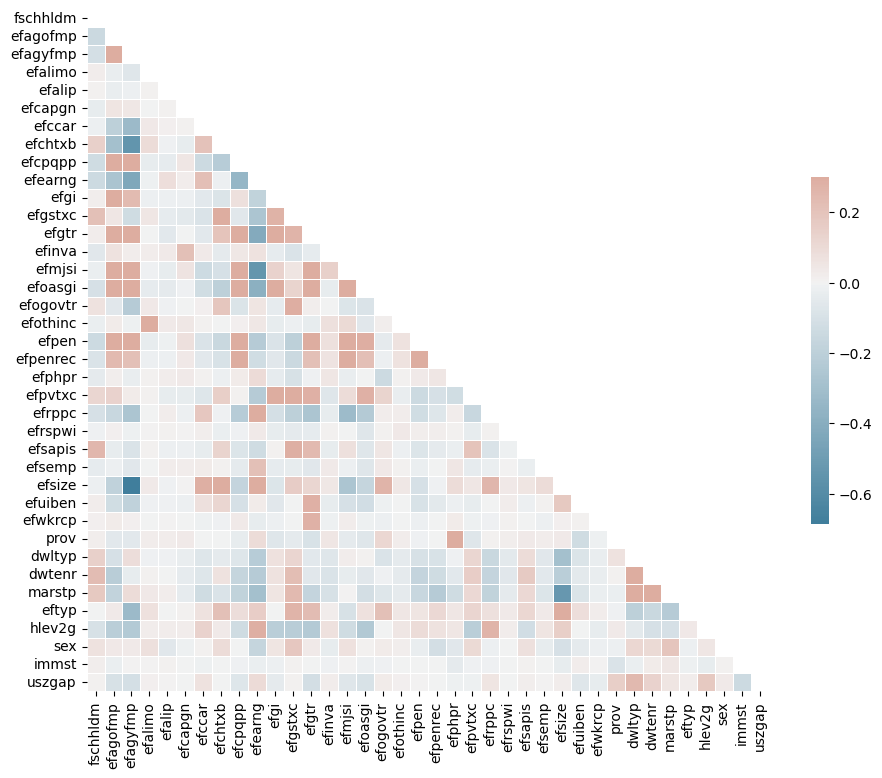

In [20]:
# Compute the correlation matrix for all variables
corr_matrix_all = new_dataset_efmjieh1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix_all, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix_all, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


Therefore, we keep all 37 explanatory variables as predictors for food insecurity.